In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt 
import pickle
import tensorly
import matplotlib.ticker as ticker
import tensorsketch
from tensorsketch.tensor_approx import TensorApprox
import warnings
warnings.filterwarnings('ignore')

Using numpy backend.
Using numpy backend.


In [2]:
def simrun_name(name, inv_factor): 
    ''' 
    Create an file name for a simulation run
    '''
    return "data/"+name+"_frk"+str(inv_factor)+".pickle"
def simplot_name(name, inv_factor): 
    return "plots/"+name+"_frk"+str(inv_factor)+".pdf" 
    '''
    Create an file name for simulation result plots 
    '''
def run_realdata_frk(data, inv_factor, name, random_seed = 1): 
    '''
    Run one pass, two pass, and HOOI on the same real world low-rank tensor data with 
    fixed rank = 1/inv_factor and varying k. 
    :param data: The dataset.
    :param inv_factor: The inverse of the increment between ks. 
    :param name: file name that store the simulation result. 
    '''
    ranks = (np.array(data.shape)/inv_factor).astype(int)
    _, _, _, hooi_rerr, _ = tensorsketch.tensor_approx.TensorApprox(data, ranks).tensor_approx('hooi')
    hooi_result = np.repeat(hooi_rerr, len(np.arange(2/inv_factor,2/5, (2/5 -1/inv_factor)/10))).tolist()
    one_pass_result = []
    two_pass_result = []
    for factor in np.arange(2/inv_factor,2/5, (2/5 -1/inv_factor)/10):  
        ks = (np.array(data.shape)*factor).astype(int)
        ss = 2*ks+1 
        sim = tensorsketch.tensor_approx.TensorApprox(data, ranks, ks, ss)
        _, _, _, two_pass_rerr, _ = sim.tensor_approx('twopass')
        _, _, _, one_pass_rerr, _ = sim.tensor_approx('onepass')
        one_pass_result.append(one_pass_rerr)
        two_pass_result.append(two_pass_rerr)
    result = [hooi_result, two_pass_result, one_pass_result] 
    pickle.dump( result, open(simrun_name(name,inv_factor), "wb" ) )
    return result

def plot_realdata_frk(data, inv_factor, name, fontsize = 18): 
    '''
    Plot the simulation result for one pass, two pass, and HOOI for the tensor data with rank = 1/inv_factor
    '''
    ranks = (np.array(data.shape)/inv_factor).astype(int)    
    kratio = np.arange(2/inv_factor,2/5, (2/5 -1/inv_factor)/10)
    result = pickle.load(open(simrun_name(name, inv_factor), "rb" ) )
    plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    plt.rc('text', usetex=True)    
    plt.figure(figsize=(6,5))
    plt.plot(kratio,result[0], label = 'HOOI', markersize = 10, linestyle = ':', marker = 'o', markeredgewidth=1,markeredgecolor='g', markerfacecolor='None') 
    plt.plot(kratio,result[1], label = 'Two Pass', markersize = 10, linestyle = '--',marker = 'X')
    plt.plot(kratio,result[2], label = 'One Pass', markersize = 10, marker = 's',markeredgewidth=1,markeredgecolor='orange', markerfacecolor='None') 
    plt.legend(loc = 'best')
    plt.title("rk/I = %s"%round(1/inv_factor,3))
    plt.xlabel('Compression Factor: $\delta_1$ = k/I')
    plt.ylabel('Relative Error')
    plt.yscale('log')
    plt.minorticks_off()
    alldata = np.concatenate(result)
    ymin = min(alldata)
    ymax = max(alldata) 
    def round_to_n(x,n): 
        return round(x,-int(np.floor(np.log10(abs(x))))+n-1) 
    ticks = [round_to_n(i,3) for i in np.arange(ymin, ymax+(ymax-ymin)/5,(ymax-ymin)/5)] 
    plt.yticks(ticks)
    plt.axes().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2e')) 
    plt.axes().title.set_fontsize(fontsize)
    plt.axes().xaxis.label.set_fontsize(fontsize)
    plt.axes().yaxis.label.set_fontsize(fontsize)
    plt.rc('legend',fontsize = fontsize)
    plt.rc('xtick', labelsize = fontsize) 
    plt.rc('ytick', labelsize = fontsize) 
    plt.tight_layout()
    plt.savefig(simplot_name(name,inv_factor))
    plt.show()

In [3]:
'''
The dataset can be downloaded from:
PSL(sea level pressure): https://www.earthsystemgrid.org/dataset/ucar.cgd.ccsm4.CESM_CAM5_BGC_LE.atm.proc.monthly_ave.PSL/file.html
BURDENDUST(Dust aerosol burden): https://www.earthsystemgrid.org/dataset/ucar.cgd.ccsm4.CESM_CAM5_BGC_LE.atm.proc.monthly_ave.BURDENDUST.html
CLOUD(cloud fraction): https://www.earthsystemgrid.org/dataset/ucar.cgd.ccsm4.CESM_CAM5_BGC_LE.atm.proc.monthly_ave.CLOUD/file.html
AODABS(Aerosol absorption optical depth 550 nm): https://www.earthsystemgrid.org/dataset/ucar.cgd.ccsm4.CESM_CAM5_BGC_LE.atm.proc.monthly_ave.AODABS/file.html
ABSORB(Aerosol absorption): https://www.earthsystemgrid.org/dataset/ucar.cgd.ccsm4.CESM_CAM5_BGC_LE.atm.proc.monthly_ave.ABSORB/file.html
SRFRAD(Net radiative flux at surface): https://www.earthsystemgrid.org/dataset/ucar.cgd.ccsm4.CESM_CAM5_BGC_LE.atm.proc.monthly_ave.SRFRAD/file.html
'''
#CLOUD = nc.Dataset("data/b.e11.BRCP85C5CNBDRD.f09_g16.013.cam.h0.CLOUD.208101-210012.nc").variables['CLOUD'][:]
#AODABS = nc.Dataset("data/b.e11.B1850C5CN.f09_g16.005.cam.h0.AODABS.040001-049912.nc").variables['AODABS'][:] 
#AODABS = AODABS.filled(AODABS.mean())
ABSORB = nc.Dataset("data/b.e11.BRCP85C5CNBDRD.f09_g16.023.cam.h0.ABSORB.208101-210012.nc").variables['ABSORB'][:]
ABSORB = ABSORB.filled(ABSORB.mean())
SRFRAD = nc.Dataset("data/b.e11.B1850C5CN.f09_g16.005.cam.h0.SRFRAD.040001-049912.nc").variables['SRFRAD'][:]
BURDENDUST = nc.Dataset("data/b.e11.B1850C5CN.f09_g16.005.cam.h0.BURDENDUST.040001-049912.nc").variables['BURDENDUST'][:] 
#PSL = nc.Dataset("data/b.e11.B1850C5CN.f09_g16.005.cam.h0.PSL.200001-209912.nc").variables['PSL'][:]

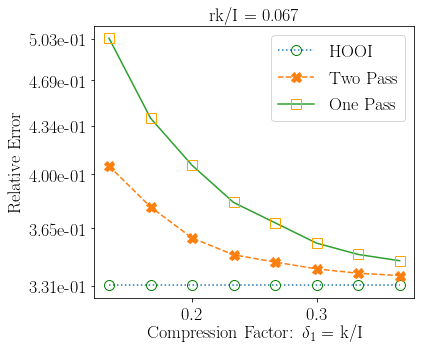

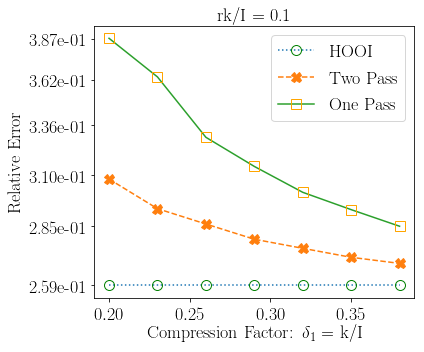

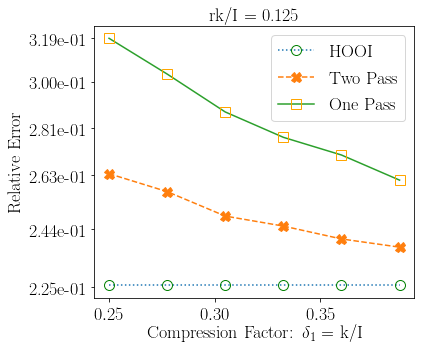

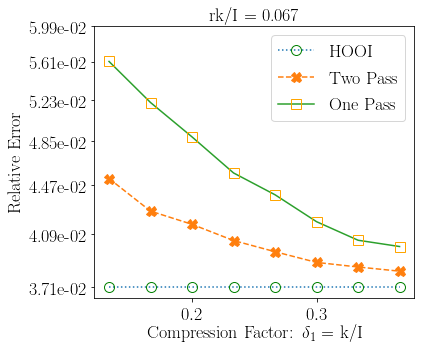

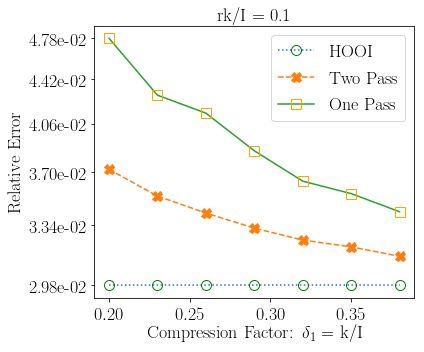

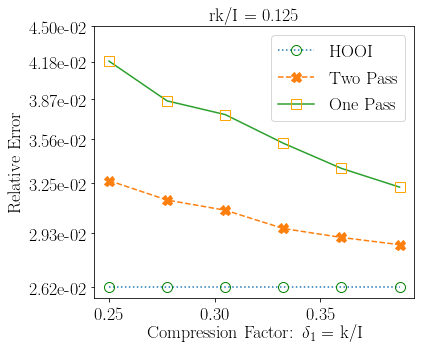

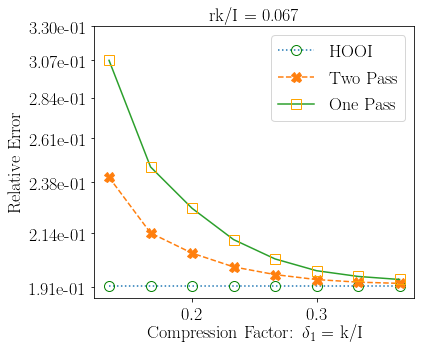

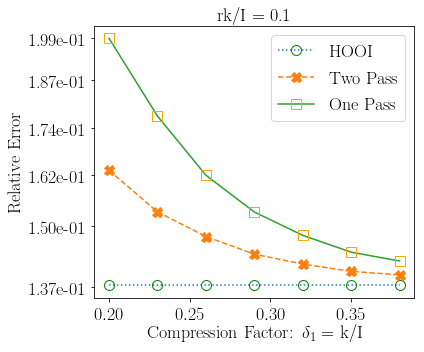

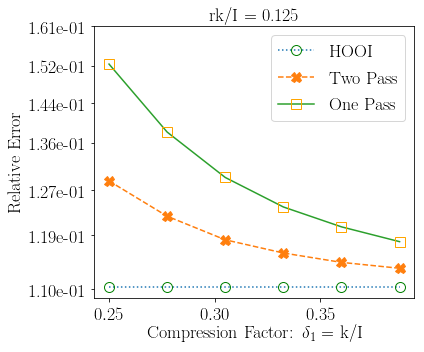

In [14]:
plot_realdata_frk(ABSORB,15,"ABSORB")
plot_realdata_frk(ABSORB,10,"ABSORB")
plot_realdata_frk(ABSORB,8,"ABSORB")
plot_realdata_frk(SRFRAD,15,"SRFRAD")
plot_realdata_frk(SRFRAD,10,"SRFRAD")
plot_realdata_frk(SRFRAD,8,"SRFRAD")
plot_realdata_frk(BURDENDUST,15,"BURDENDUST")
plot_realdata_frk(BURDENDUST,10,"BURDENDUST")
plot_realdata_frk(BURDENDUST,8,"BURDENDUST")

In [16]:
def simplotlog_name(name, inv_factor): 
    return "plots/"+name+"_frk"+str(inv_factor)+"log.pdf" 
def plot_realdata_frklog(data, inv_factor, name, fontsize = 18): 
    ranks = (np.array(data.shape)/inv_factor).astype(int)    
    kratio = np.arange(2/inv_factor,2/5, (2/5 -1/inv_factor)/10)
    result = pickle.load(open(simrun_name(name, inv_factor), "rb" ) )
    plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    plt.rc('text', usetex=True)    
    plt.figure(figsize=(6,5))
    two_pass_result = [np.log(result[1][i]/result[0][i]) for i in range(len(result[0]))]
    one_pass_result = [np.log(result[2][i]/result[0][i]) for i in range(len(result[0]))]
    plt.plot(kratio,two_pass_result, label = 'Two Pass', markersize = 10, linestyle = '--',marker = 'X')
    plt.plot(kratio,one_pass_result, label = 'One Pass', markersize = 10, marker = 's',markeredgewidth=1,markeredgecolor='orange', markerfacecolor='None') 
    plt.legend(loc = 'best')
    plt.title("rk/I = %s"%round(1/inv_factor,3))
    plt.xlabel('Compression Factor: $\delta_1$ = k/I')
    plt.ylabel('log(Relative Error)')
    plt.minorticks_off()
    alldata = np.concatenate([two_pass_result,one_pass_result])
    ymin = 0
    ymax = max(alldata) 
    def round_to_n(x,n): 
        if x == 0: 
            return 0
        else: 
            return round(x,-int(np.floor(np.log10(abs(x))))+n-1) 
    ticks = [round_to_n(i,3) for i in np.arange(ymin, ymax+(ymax-ymin)/5,(ymax-ymin)/5)] 
    plt.yticks(ticks)
    plt.axes().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2e')) 
    plt.axes().title.set_fontsize(fontsize)
    plt.axes().xaxis.label.set_fontsize(fontsize)
    plt.axes().yaxis.label.set_fontsize(fontsize)
    plt.rc('legend',fontsize = fontsize)
    plt.rc('xtick', labelsize = fontsize) 
    plt.rc('ytick', labelsize = fontsize) 
    plt.tight_layout()
    plt.savefig(simplotlog_name(name,inv_factor))
    plt.show()

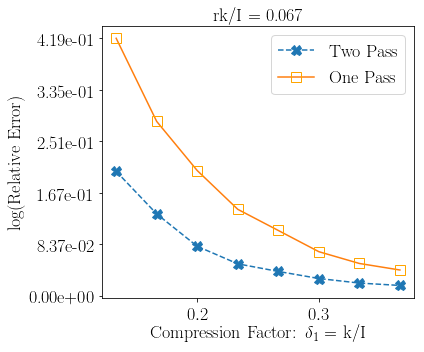

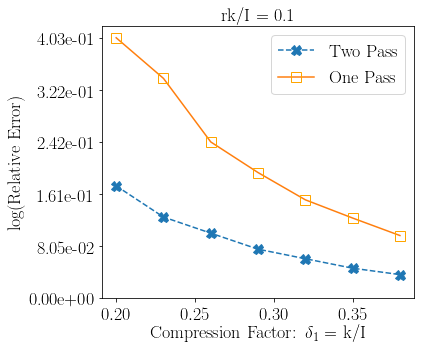

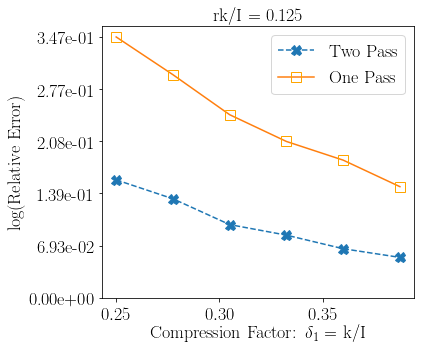

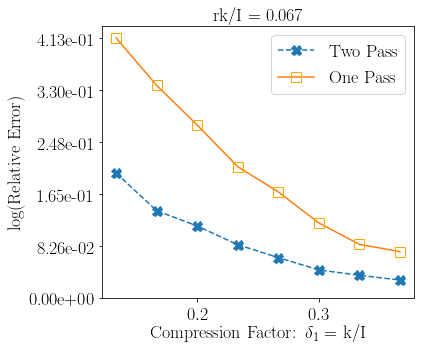

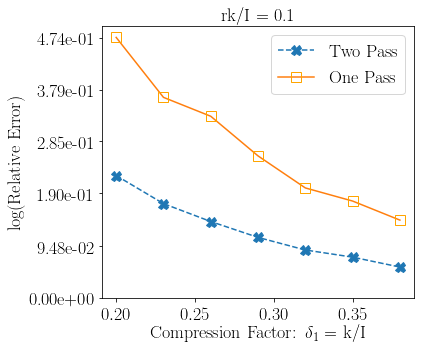

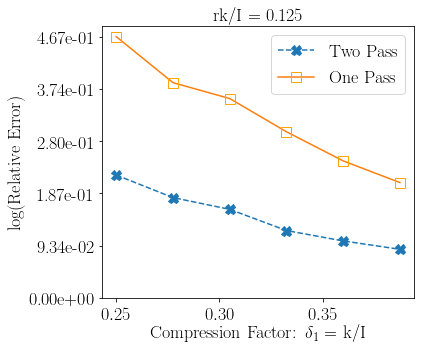

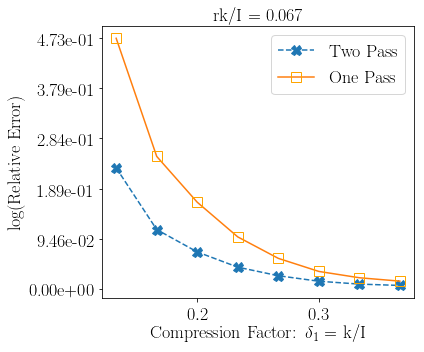

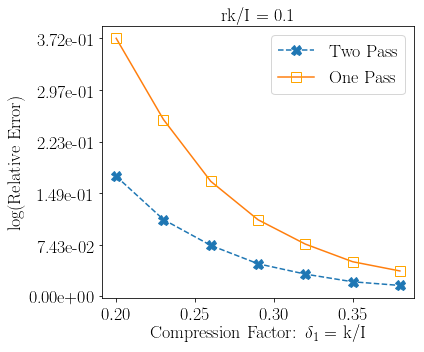

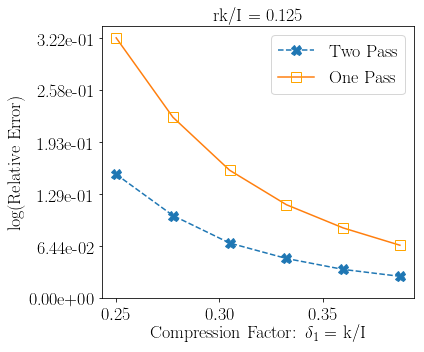

In [17]:
plot_realdata_frklog(ABSORB,15,"ABSORB")
plot_realdata_frklog(ABSORB,10,"ABSORB")
plot_realdata_frklog(ABSORB,8,"ABSORB")
plot_realdata_frklog(SRFRAD,15,"SRFRAD")
plot_realdata_frklog(SRFRAD,10,"SRFRAD")
plot_realdata_frklog(SRFRAD,8,"SRFRAD")
plot_realdata_frklog(BURDENDUST,15,"BURDENDUST")
plot_realdata_frklog(BURDENDUST,10,"BURDENDUST")
plot_realdata_frklog(BURDENDUST,8,"BURDENDUST")

In [4]:
def run_realdata_fk(data,name,random_seed = 1): 
    '''
    Run one pass, two pass, and HOOI on the same real world low-rank tensor data with 
    same k and varying r. 
    :param data: The dataset.
    :param name: file name that store the simulation result. 
    '''
    X = data
    kratio = 1/4
    r0ratio = 1/20
    rratios = np.arange((r0ratio),(1/5),(1/100))
    dim = np.array(X.shape)
    _, _, _, hooi_rerr, _ = tensorsketch.tensor_approx.TensorApprox(X, (dim*r0ratio).astype(int)).tensor_approx('hooi') 
    hooi_result = np.repeat(hooi_rerr, len(rratios))
    two_pass_result = np.zeros(len(rratios))
    one_pass_result = np.zeros(len(rratios))
    for idx, rratio in enumerate(rratios):   
        sim = tensorsketch.tensor_approx.TensorApprox(X, (dim*rratio).astype(int), (dim*kratio).astype(int), (dim*kratio).astype(int)*2+1)
        _, _, _, two_pass_rerr, _ = sim.tensor_approx('twopass')
        _, _, _, one_pass_rerr, _ = sim.tensor_approx('onepass')
        one_pass_result[idx] = one_pass_rerr
        two_pass_result[idx] = two_pass_rerr
    sim_list = [two_pass_result,one_pass_result,hooi_result]
    pickle.dump( sim_list, open("data/"+name+"_fk.pickle", "wb" ) )
    return sim_list

In [ ]:
run_realdata_fk(BURDENDUST,"BURDENDUST")  

(16,)


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy b

In [ ]:
run_realdata_fk(ABSORB,"ABSORB")

(16,)


Using numpy backend.


0


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


1


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


2


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


3


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


4


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


5


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


6


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


7


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


8


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


9


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


10


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


In [37]:
run_realdata_fk(SRFRAD,"SRFRAD")

(2,)


Using numpy backend.


0


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


1


Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.
Using numpy backend.


[array([0.04509614, 0.04268526]),
 array([0.05062864, 0.04945875]),
 array([0.0419349, 0.0419349], dtype=float32)]

In [19]:
def plot_realdata_fk(data, name,title, random_seed = 1,fontsize = 18): 
    X = data 
    sim_list = pickle.load(open("data/"+name+"_fk.pickle","rb"))
    X = data
    
    kratio = 1/5
    r0ratio = 1/20
    rratios = np.arange((r0ratio),(1/5),(1/100))
    dim = np.array(X.shape)
    
    plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    plt.rc('text', usetex=True)    
    plt.figure(figsize=(6,5))    
    two_pass_result = [np.log(sim_list[0][i]/sim_list[2][i]) for i in range(len(sim_list[2]))]
    one_pass_result = [np.log(sim_list[1][i]/sim_list[2][i]) for i in range(len(sim_list[2]))]
    
    plt.plot(rratios,two_pass_result, label = 'Two Pass', markersize = 10, linestyle = '--',marker = 'X')
    plt.plot(rratios,one_pass_result, label = 'One Pass', markersize = 10, marker = 's',markeredgewidth=1,markeredgecolor='orange', markerfacecolor='None') 
    plt.legend(loc = 'best')
    plt.title(title)
    plt.xlabel('Relative Rank: $rk/I$')
    plt.ylabel('log(Relative Error)')
    plt.minorticks_off()
    alldata = np.concatenate([one_pass_result,two_pass_result])
    ymin = min(alldata)
    ymax = max(alldata) 
    def round_to_n(x,n): 
        if x == 0: 
            return 0
        else: 
            return round(x,-int(np.floor(np.log10(abs(x))))+n-1) 
    ticks = [round_to_n(i,3) for i in np.arange(ymin, ymax+(ymax-ymin)/5,(ymax-ymin)/5)] 
    plt.yticks(ticks)
    plt.axes().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2e')) 
    plt.axes().xaxis.set_major_locator(ticker.MaxNLocator(10))
    plt.axes().title.set_fontsize(fontsize)
    plt.axes().xaxis.label.set_fontsize(fontsize)
    plt.axes().yaxis.label.set_fontsize(fontsize)
    plt.rc('legend',fontsize = fontsize)
    plt.rc('xtick', labelsize = fontsize) 
    plt.rc('ytick', labelsize = fontsize) 
    plt.axhline(0, color='black',linewidth = 1)
    plt.tight_layout()
    plt.savefig("plots/"+name+"_fk.pdf")
    plt.show()

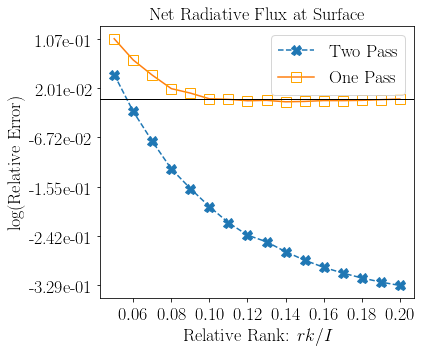

In [20]:
plot_realdata_fk(SRFRAD,"SRFRAD", "Net Radiative Flux at Surface")

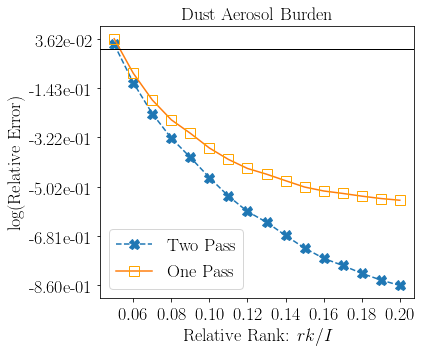

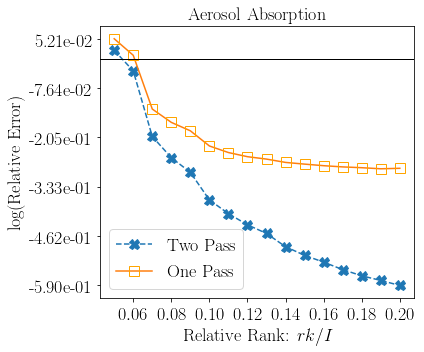

In [21]:
#plot_realdata_fk(AODABS,"AODABS", "Aerosol Absorption Optical Depth 550 nm")
plot_realdata_fk(BURDENDUST,"BURDENDUST", "Dust Aerosol Burden")
plot_realdata_fk(ABSORB,"ABSORB", "Aerosol Absorption")